In [1]:
import pandas as pd


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split


from ann import ANN

from matplotlib import pyplot as plt

In [2]:
def clean_data(df):
    # Remove rows with missing values
    df = df.dropna()

    # Remove duplicates
    df = df.drop_duplicates()

    id = df['id']

    # Convert categorical columns to category type
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = pd.factorize(df[col])[0]

    # Extract features and labels
    if 'Calories' not in df.columns:
        X = df.drop(columns=['id'])  # Assuming 'target' is the label column
        y = None
    else:
        X = df.drop(columns=['Calories', 'id'])  # Assuming 'target' is the label column
        y = df['Calories']

    # Normalize numerical columns
    for col in X.select_dtypes(include=['int64', 'float64']).columns:
        X[col] = (X[col] - X[col].mean()) / X[col].std()

    

    return X, y, id

In [3]:
def split_tensor(tensor, labels, train_size=0.7, val_size=0.2, test_size=0.1, random_state=None):
    """Splits a tensor into train, validation, and test sets.

    Args:
        tensor (torch.Tensor): The tensor to split.
        train_size (float): The proportion of the data to use for training.
        val_size (float): The proportion of the data to use for validation.
        test_size (float): The proportion of the data to use for testing.
        random_state (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        tuple: A tuple containing the training, validation, and test tensors.
    """
    if sum([train_size, val_size, test_size]) != 1:
        raise ValueError("Train, val, and test sizes must sum to 1")

    dataset = TensorDataset(tensor, labels)
    total_size = len(dataset)
    train_len = int(total_size * train_size)
    val_len = int(total_size * val_size)
    test_len = total_size - train_len - val_len

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(random_state) if random_state else None
    )

    return train_dataset, val_dataset, test_dataset

In [4]:
# Read training data
train = pd.read_csv('train.csv')

# Read test data
test = pd.read_csv('test.csv')

train_cleaned, labels, _ = clean_data(train)

# Convert to PyTorch Dataset
train_tensor = torch.tensor(train_cleaned.values, dtype=torch.float32)
labels = torch.tensor(labels.values, dtype=torch.float32)
train_dataset, val_dataset, test_dataset = split_tensor(train_tensor, labels, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [6]:
# Init model and hyperparameters
model = ANN(input_size=train_cleaned.shape[1], hidden_size=64, output_size=1)
learning_rate = 0.00005
weight_decay = 0.0001
num_epochs = 100
criterion = RMSLELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [ ]:
#Training loop
t_loss = 0
v_loss = 0
train_loss = []
val_loss = []

best_val_loss = float('inf')
for epoch in range(num_epochs):
    t_loss = 0
    model.train()
    for i, (inputs,outputs) in enumerate(train_loader):
        # Forward pass
        preds = model(inputs)
        loss = criterion(preds, outputs.view(-1, 1))  # Reshape outputs to match preds
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss += loss.item()


    train_loss.append(t_loss / len(train_loader))

    # Validation loop
    model.eval()
    with torch.no_grad():
        v_loss = 0
        for inputs, outputs in val_loader:
            preds = model(inputs)
            loss = criterion(preds, outputs.view(-1, 1))  # Reshape outputs to match preds
            v_loss += loss.item()

        val_loss.append(v_loss / len(val_loader))

        if best_val_loss > val_loss[-1]:
            best_val_loss = val_loss[-1]
            torch.save(model.state_dict(), 'best_model.pth')

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f} Validation Loss: {val_loss[-1]:.4f}')


Epoch [1/100], Train Loss: 1.6886 Validation Loss: 0.4868
Epoch [2/100], Train Loss: 0.2563 Validation Loss: 0.1594
Epoch [3/100], Train Loss: 0.1366 Validation Loss: 0.1238
Epoch [4/100], Train Loss: 0.1150 Validation Loss: 0.1083
Epoch [5/100], Train Loss: 0.1022 Validation Loss: 0.0980
Epoch [6/100], Train Loss: 0.0933 Validation Loss: 0.0902
Epoch [7/100], Train Loss: 0.0863 Validation Loss: 0.0841
Epoch [8/100], Train Loss: 0.0813 Validation Loss: 0.0800
Epoch [9/100], Train Loss: 0.0774 Validation Loss: 0.0767
Epoch [10/100], Train Loss: 0.0749 Validation Loss: 0.0750
Epoch [11/100], Train Loss: 0.0734 Validation Loss: 0.0735
Epoch [12/100], Train Loss: 0.0721 Validation Loss: 0.0724
Epoch [13/100], Train Loss: 0.0711 Validation Loss: 0.0716
Epoch [14/100], Train Loss: 0.0704 Validation Loss: 0.0708
Epoch [15/100], Train Loss: 0.0698 Validation Loss: 0.0702
Epoch [16/100], Train Loss: 0.0692 Validation Loss: 0.0698
Epoch [17/100], Train Loss: 0.0687 Validation Loss: 0.0694
Epoch 

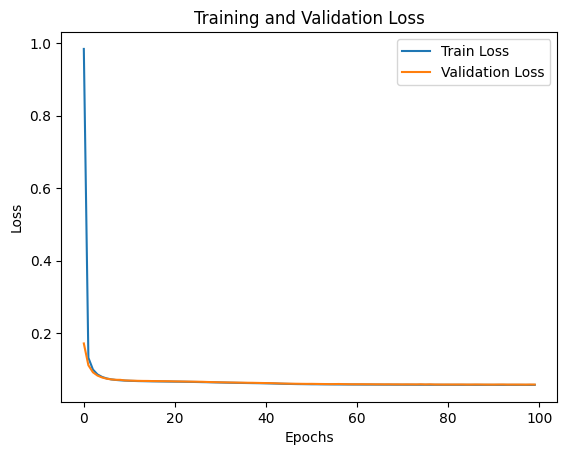

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the model on the test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, outputs in test_loader:
        preds = model(inputs)
        loss = criterion(preds, outputs.view(-1, 1))  # Reshape outputs to match preds
        test_loss += loss.item()
    test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
# Save the model

/var/folders/3h/5c18xcjn2r37gl5v4wdg5sh80000gn/T/ipykernel_8145/1770042031.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.p

Test Loss: 0.0570


In [ ]:
test_cleaned, _, id= clean_data(test)
test_tensor = torch.tensor(test_cleaned.values, dtype=torch.float32)
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        preds = model(inputs[0])
        predictions.append(preds)


predictions = torch.cat(predictions).numpy()
predictions = predictions.flatten()

# Save id and predictions to CSV
id = id.values
predictions = pd.DataFrame({'id': id, 'Calories': predictions})
predictions = predictions.sort_values(by='id')
predictions.reset_index(drop=True, inplace=True)
predictions.to_csv('submission.csv', index=False)